In [5]:
import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from ultralytics.utils.plotting import Annotator

import shutil



In [6]:
class DentexDataset:
    """A class for loading and processing dental x-ray images.

    Args:
        root_dir: The path to the root directory of the dataset.
        train: Whether to load the training or validation set.
        task: The task to perform on the dataset.
        sample: Whether to sample the dataset.

    Raises:
        ValueError: If the `task` argument is not one of `quadrant`, `quadrant_enumeration`, or `quadrant_enumeration_disease`.
    """
    def __init__(self, root_dir: Path, train=True, task='quadrant_enumeration', sample=False):
        self.root_dir = root_dir
        self.train = train
        self.task = task

        if task not in ['quadrant', 'quadrant_enumeration', 'quadrant_enumeration_disease']:
            raise ValueError(f'Invalid task: {task}')

        if train:
            task_root_dir = self.root_dir / 'training_data' / task
            with open(task_root_dir / f'train_{task}.json') as f:
                self.json_content = json.load(f)
        else:
            task_root_dir = self.root_dir / 'validation_data' / 'quadrant_enumeration_disease'
            self.json_content = None

        self.task_root_dir = task_root_dir
        self.img_paths = list((task_root_dir / 'xrays').glob('*.png'))
        self.img_names = [i.name for i in self.img_paths]

        image_id_dict = {i['id']: i['file_name'] for i in self.json_content['images']}

        annotations = {}
        for annotation in self.json_content['annotations']:
            image_id = annotation['image_id']
            image_name = image_id_dict[image_id]
            bbox = self.xywh_to_xyxy(annotation['bbox'])
            name = f'{annotation["category_id_1"] + 1}{annotation["category_id_2"] + 1}'

            if image_name not in annotations.keys():
                annotations[image_name] = {}

            annotations[image_name][name] = np.array(bbox)

        annotations = pd.DataFrame.from_dict(annotations, orient='index')

        if sample:
            annotations = annotations.sample(frac=0.275)

        self.annotations = annotations.sort_index()

        self.train_annotations = annotations.sample(frac=0.8)
        self.val_annotations = annotations[~annotations.index.isin(self.train_annotations.index)]

    def __getitem__(self, index):
        if isinstance(index, int):
            anno = self.annotations.iloc[index]
            name = anno.name
        elif isinstance(index, str):
            anno = self.annotations.loc[index]
            name = anno.name
        else:
            raise TypeError('index should be int or str.')

        im = cv2.imread(str(self.task_root_dir / 'xrays' / name))

        return im, anno

    def image_full_path(self, image_name):
        return self.task_root_dir / 'xrays' / image_name

    def plot(self, image_name):
        # im = cv2.imread(str(self.task_root_dir / 'xrays' / image_name))
        im, anno = self[image_name]

        annotator = Annotator(im, line_width=3, example=image_name)

        for tooth_number, xyxy in anno.items():
            if isinstance(xyxy, float):
                continue
            annotator.box_label(xyxy, str(tooth_number), color=(255, 0, 0))

        im1 = annotator.result()
        plt.imshow(im1)
        plt.show()

    def yolo_yaml_gen(self, path=None):
        if not path:
            path = self.task_root_dir / 'yolov8'

        image_path = path / 'images'
        label_path = path / 'labels'

        train_image = image_path / 'train'
        val_image = image_path / 'val'
        train_label = label_path / 'train'
        val_label = label_path / 'val'

        names = list(self.annotations.columns.sort_values())
        inv_names = {name: i for i, name in enumerate(names)}
        names = [f'{i}: {name}' for i, name in enumerate(names)]

        names_str = '\n  '.join(names)

        yaml_file = f'''
path: {path}
train: {train_image.relative_to(path)}
val: {val_image.relative_to(path)}

names:
  {names_str}
        '''

        def make_dirs(dirs):
            for i in dirs:
                os.mkdir(i)

        yolov8_dirs = [path, image_path, train_image, val_image, label_path, train_label, val_label]
        # Dir check & create
        if os.path.isdir(path):
            shutil.rmtree(path)
        make_dirs(yolov8_dirs)

        # YAML file gen
        with open(path / 'dentex.yaml', 'w') as f:
            f.write(yaml_file)

        # Write image and label data
        dst_triple = (
            (self.train_annotations, train_image, train_label),
            (self.val_annotations, val_image, val_label),
        )

        for anno_dst, image_dst, label_dst in dst_triple:
            self.yolo_write_image_label_data(anno_dst, image_dst, label_dst, inv_names)

        return path / 'dentex.yaml'

    def yolo_write_image_label_data(self, anno_dst, image_dst, label_dst, inv_names):
        """Processes annotation and image data for tooth segmentation.

        Args:
            anno_dst: The destination directory for the annotation files.
            image_dst: The destination directory for the image files.
            label_dst: The destination directory for the label files.
            inv_names: A dictionary mapping tooth names to tooth numbers.

        Returns:
            None.
        """
        index = anno_dst.index
        for file_name in index:
            # Image file processing
            org_path = self.image_full_path(file_name)
            dst_path = image_dst / file_name

            shutil.copy(org_path, dst_path)

            # Label file processing
            im = cv2.imread(str(org_path))
            h, w, _ = im.shape

            label_rows = []
            labels = anno_dst.loc[file_name]
            tooth_names = labels.index
            for tooth_name in tooth_names:
                label = labels[tooth_name]
                if isinstance(label, float):
                    continue

                label = label / [w, h, w, h]

                label_formatted = list(map(lambda s: '%.5f' % s, label))
                label_str = ' '.join(label_formatted)

                tooth_number = inv_names[tooth_name]
                label_row = f'{tooth_number:2d} {label_str}'

                label_rows.append(label_row)

            file_name = Path(file_name)
            file_name = file_name.with_suffix('.txt')
            label_file_path = label_dst / file_name
            with open(label_file_path, 'w') as f:
                f.write('\n'.join(label_rows))

    @staticmethod
    def xywh_to_xyxy(box):
        """Converts a bounding box from xywh format to xyxy format.

        Args:
        box: A list of four numbers, representing the bounding box in xywh format.

        Returns:
        A list of four numbers, representing the bounding box in xyxy format.
        """
        x, y, w, h = box
        return [x, y, x + w, y + h]


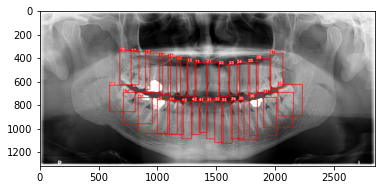

In [7]:
load_dotenv()
data_dir = Path(os.getenv('DATASET_DIR')) / 'DENTEX CHALLENGE 2023'

a = DentexDataset(root_dir=data_dir, sample=True)

# a.annotations
image_name = a.annotations.index[0]
a.plot(image_name)


YOLOv8 YAML file generate

In [8]:
yaml_root = Path('../data/dentex-sample').absolute()
yaml_path = a.yolo_yaml_gen(path=yaml_root)
